## Archivo para leer los epitopes de IEDB de un CSV 


In [ ]:
import csv
import pandas as pd
A=pd.read_csv('/Users/paolanunez/Documents/epitope_humanIEDB.csv',sep=';')

In [ ]:
A.columns

Index(['Object Type', 'Description', 'Starting Position', 'Ending Position',
       'Antigen Accession', 'Parent Protein Accession', 'Length', 'Unnamed: 7',
       'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'],
      dtype='object')

In [ ]:
A.head()

,Object Type,Description,Starting Position,Ending Position,Antigen Accession,Parent Protein Accession,Length,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,Linear peptide,AAGIGILTV,27.0,35.0,Q16655.1,Q16655,9,NaN,NaN,NaN,NaN,NaN
1,Linear peptide,AAGIGILTVI,27.0,36.0,Q16655.1,Q16655,10,NaN,NaN,NaN,NaN,NaN
2,Linear peptide,AAPLILSRI,17.0,25.0,P07288.2,P07288,9,NaN,NaN,NaN,NaN,NaN
3,Linear peptide,AAPPVAPA,69.0,76.0,P04637.2,A0A0U1RQC9,8,NaN,NaN,NaN,NaN,NaN
4,Linear peptide,AARPATSTL,1073.0,1081.0,E7EUU4,E7EUU4,9,NaN,NaN,NaN,NaN,NaN


In [ ]:
seq=A['Description']
id_=A['Parent Protein Accession']
begin=A['Starting Position']
end=A['Ending Position']
df = pd.DataFrame(A,columns=['Description','Parent Protein Accession','Antigen Accession','Starting Position','Ending Position','Length'])

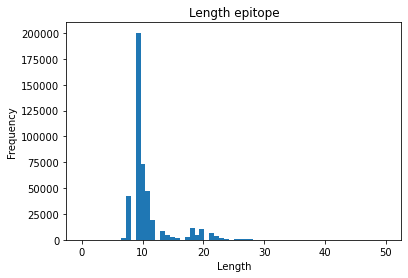

In [ ]:
length_frq = df['Length']
counts, bins, bars=plt.hist(length_frq,range=(min(length_frq),50),bins=max(length_frq)-min(length_frq))
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.title('Length epitope')
plt.show()

In [ ]:
df.to_csv('/Users/paolanunez/Documents/TFG_PaolaNuñez/bert_repo/epitope_human.txt', header=True, index=False, sep='\t', mode='w')

## Guardar las sequencias completas de las proteínas que contienen los epitopes

In [ ]:
import numpy as np
import scipy as sc
import pandas as pd
import itertools
import textwrap
import time
import csv
from collections import Counter
import matplotlib.pyplot as plt
import requests
import json
import string

In [ ]:
output=open('Epitope_SEQUENCES.csv', 'w') #Archivo donde guardar los epitopes 
writer = csv.writer(output, delimiter=',')
readfile = open('/Users/paolanunez/Documents/TFG_PaolaNuñez/bert_repo/epitope_human.txt', 'r')
for line in readfile:
    line1 = line.split('\t')
    Uniprotacc=line1[1].split('\n')[0]
    Epitope=line1[0]
    resp = requests.get('http://3dbionotes.cnb.csic.es/api/info/Uniprot/'+Uniprotacc)
    data =resp.text
    writer.writerow([Uniprotacc,Epitope,seq])

In [ ]:
output=open('Epitope_SEQUENCES.csv', 'w') #Archivo donde guardar los epitopes 
writer = csv.writer(output, delimiter=',')
readfile = open('/Users/paolanunez/Documents/TFG_PaolaNuñez/bert_repo/epitope_human.txt', 'r')
for line in readfile:
    line1 = line.split('\t')
    Uniprotacc=line1[1].split('\n')[0]
    if Uniprotacc =='':
        Uniprotacc=line1[2].split('.')[0]
    Epitope=line1[0]
    try:
        start=int(float(line1[3]))
        end=int(float(line1[4].split('\n')[0]))
        resp = requests.get('http://3dbionotes.cnb.csic.es/api/info/Uniprot/'+Uniprotacc)
        data =resp.text
        seq=data
        writer.writerow([Uniprotacc,Epitope,start,end,seq])
    except:
        start=''
        end=''
        resp = requests.get('http://3dbionotes.cnb.csic.es/api/info/Uniprot/'+Uniprotacc)
        data =resp.text
        if '>' in data or '/' in data:
            seq=''
            writer.writerow([Uniprotacc,Epitope,start,end,seq])
        else:
            seq=data
            writer.writerow([Uniprotacc,Epitope,start,end,seq])

## Crear las sequencias negativas

1. A partir del archivo anterior en el que guardamos el epitope, el uniprot id de origen y la sequencia completa, vamos a construir un archivo en el que guardemos los trozos de sequencia negativa.

Ejemplo de como vamos a sacar los intervalos que se solapan de los epitopes para eliminar sus sequencias de la sequencia

In [ ]:
a=['Q16655','AAGIGILTV',27,35,'MPREDAHFIYGYPKKGHGHSYTTAEEAAGIGILTVILGVLLLIGCWYCRRRNGYRALMDKSLHVGTQCALTRRCPQEGFDHRDSKVSLQEKNCEPVVPNAPPAYEKLSAEQSPPPYSP']
b=['Q16655','AAGIGILTVI',27,36,'MPREDAHFIYGYPKKGHGHSYTTAEEAAGIGILTVILGVLLLIGCWYCRRRNGYRALMDKSLHVGTQCALTRRCPQEGFDHRDSKVSLQEKNCEPVVPNAPPAYEKLSAEQSPPPYSP']
c=['Q16655','AAGIGILTVI',38,42,'MPREDAHFIYGYPKKGHGHSYTTAEEAAGIGILTVILGVLLLIGCWYCRRRNGYRALMDKSLHVGTQCALTRRCPQEGFDHRDSKVSLQEKNCEPVVPNAPPAYEKLSAEQSPPPYSP']

df=pd.DataFrame([a,b,c],columns=['Uniprot', 'Epitope', 'Begin','End','SEQ'])
df.Epitope.unique()

array(['AAGIGILTV', 'AAGIGILTVI'], dtype=object)

In [ ]:
df['SEQ'][1].split('AAGIGILTV')
df['SEQ'][1].find('AAGIGILTV') #indice de inicio de la subcadena

26

In [ ]:
#Codigo para coger de cada Uniprot solo los epitopes más largos que sobreponen.

import pandas as pd
a=['Q16655','AAGIGILTV',27,35,'MPREDAHFIYGYPKKGHGHSYTTAEEAAGIGILTVILGVLLLIGCWYCRRRNGYRALMDKSLHVGTQCALTRRCPQEGFDHRDSKVSLQEKNCEPVVPNAPPAYEKLSAEQSPPPYSP']
b=['Q16655','AAGIGILTVI',27,36,'MPREDAHFIYGYPKKGHGHSYTTAEEAAGIGILTVILGVLLLIGCWYCRRRNGYRALMDKSLHVGTQCALTRRCPQEGFDHRDSKVSLQEKNCEPVVPNAPPAYEKLSAEQSPPPYSP']
c=['Q16655','AAGIGILTVI',38,42,'MPREDAHFIYGYPKKGHGHSYTTAEEAAGIGILTVILGVLLLIGCWYCRRRNGYRALMDKSLHVGTQCALTRRCPQEGFDHRDSKVSLQEKNCEPVVPNAPPAYEKLSAEQSPPPYSP']

df=pd.DataFrame([a,b,c],columns=['Uniprot', 'Epitope', 'Begin','End','SEQ'])
x=df.Epitope.unique()
word=''
for element in x:
    if len(element) > len(word):
        word=element
print(word)
epi=[word]
for i in x:
    if word.find(i)==-1:
        epi.append(i)
print(epi)

In [ ]:
import pandas as pd

#### SE CORRESPONDE CON EPITOPES1_0.PY. SLIDING WINDOW

df1=pd.read_csv('Epitope_SEQUENCES.csv',names=['Uniprot', 'Epitope', 'Begin','End','SEQ']) #Leo el fichero que tiene epitopos y secuencia entera de prot
x=df1.Uniprot.unique()#Cojo solo el identificador de cada proteína una vez
for i in x: #itero por cada proteína
    is_epi = df1.loc[:, 'Uniprot'] == i #miro para todas las filas de mi database las entradas que tienen el mismo identificador de proteina
    df_m= df1.loc[is_epi] #hago una nueva df con las entries de la misma proteina
    epi_uni=df_m.Epitope.unique() #cojo las secuencias de epítopos diferentes
    word=''
    for element in epi_uni:  #cojo el epítopo más largo
        if len(element) > len(word):
            word=element
    epi=[word]
    for i in epi_uni:
        if word.find(i)==-1:  #miro si el resto de epítopos descartados forman tienen la misma secuencia que el elegido pero más corta. Si no es la misma añado ese epítopo también
            epi.append(i)
    print(epi)
    interval=[]
    for y in epi:
        SEQ= df_m.iloc[1,4] #cojo la secuencia de proteínas entera
        init_pos=SEQ.find(y) #encuentro dónde empieza el epítopo
        len_epi=len(y) #encuentro la longitud del epítopo
        if init_pos!=-1:
                interval.append([init_pos,init_pos+len_epi-1]) #Tengo el intervalo de posiciones de inicio y fin del epítopo
    union = []
    for begin,end in sorted(interval):  #no tengo claro lo que es union
        if union and union[-1][1] >= begin - 1:
            union[-1][1] = max(union[-1][1], end)
        else:
            union.append([begin, end])
    print(union)  
    tex=[]
    tex.append(SEQ)
    try:   #tengo una lista de números = a la seq. Tendré uno en los puntos en los aa en que sea un epítopo y cero en los que no
        NUM=np.zeros(len(SEQ))
        for begin,end in union:
            tex.append(SEQ[begin:end])
            NUM[begin:end]=1
        
        tex.append(NUM)
    except:
        pass
    begin=0
    end=30
    try:
        if SEQ.isupper(): #check if sequence is upper case
            while end<=len(SEQ): #compruebo que no intente coger aa una vez terminada toda la secuencia
                mini_seq=SEQ[begin:end] #cojo la parte de la secuencia en la que estoy
                mini_num=NUM[begin:end] #cojo el vector de 0 y 1
                non_zero_els = np.count_nonzero(mini_num) #cuento cuántos elementos son diferentes a cero, es decir, parte del epítopo
                tag=0
                if non_zero_els>=15: #si hay más de 15 aa del epítopo (aunque no esté entero lo considero). El 50% de la secuencia es epítopo
                    tag=1
                else:
                    for i in epi:
                        if mini_seq.find(i)!=-1: #si el epítopo está completamente contenido en mi secuencia
                            tag=1
                #csv_file_epi.writerow([mini_seq,tag])

                begin+=1
                end+=1
    except:
        pass

       
      

['KLQDGSIKMK + OX(M9)', 'AAPLILSRI', 'HPEDTGQVF', 'HPQKVTKFM', 'YTKVVHYRK', 'VISNDVCAQV', 'VKVNIIQEEY', 'DLQALKESLQ', 'GQVIKAWDI', 'GSIQILIKT', 'LRPLPILL']


Como conseguir los trozos de 30 aminoacidos de las partes negativas y formar los partes positivas de epitopes de 30 aminoacidos

In [ ]:
#Ejemplo de prueba. Abro mi fichero con epítopos y proteínas. TROZOS muestra la secuencia de proteina original 
#separada por el epítopo. Divido esa secuencia en sub secuencias de 30aa con wrap. Compruebo que en efecto cada secuencia 
#tiene 30aa y lo guardo en mi file.
from textwrap import wrap
with open('Prueba.txt', 'w') as filehandle1:
    for index,row in df.iterrows():
        TROZOS=row['SEQ'].split(row['Epitope'])
        for i in TROZOS:
            final=wrap(i,30)
            for iteml in final:
                if len(iteml)==30:
                    filehandle1.write('%s\t0\n' % iteml)
                

In [ ]:
#Ejemplo Prueba:Este solo nos devuelve los epitopes centrados en la ventana
for index,row in df.iterrows():
    init_pos=row['SEQ'].find(row['Epitope'])
    len_epi=len(row['Epitope'])
    rest=30-len_epi
    rest_left=int(rest/2)
    rest_rigth=rest-rest_left
    final_pos=init_pos+len_epi
    X=row['SEQ'][init_pos-rest_left:final_pos+rest_rigth]
    print(X)

HGHSYTTAEEAAGIGILTVILGVLLLIGCW
HGHSYTTAEEAAGIGILTVILGVLLLIGCW
HGHSYTTAEEAAGIGILTVILGVLLLIGCW


In [ ]:
#Este nos crea ventanas que tienen los epitopes centrados y descentrados. 
#Según este código solo tenemos label 1 si el epítopo entero está contenido. Sara también contempla si el 50% de la ventana es epítopo
a=['AAGIGILTV','MPREDAHFIYGYPKKGHGHSYTTAEEAAGIGILTVILGVLLLIGCWYCRRRNGYRALMDKSLHVGTQCALTRRCPQEGFDHRDSKVSLQEKNCEPVVPNAPPAYEKLSAEQSPPPYSP']
init_pos=a[1].find(a[0])
len_epi=len(a[0])
rest=30-len_epi
left=rest+5
rigth=-5
X=a[1][init_pos-left:init_pos+len_epi+rigth]
X=X+'\t 0'
print(X)
while left!=-5:
    left=left-1
    rigth=rigth+1
    X=a[1][init_pos-left:init_pos+len_epi+rigth]
    if X.find(a[0])==-1:
        X=X+'\t 0'
    else:
        X=X+'\t 1'
    print(X)

MPREDAHFIYGYPKKGHGHSYTTAEEAAGI	 0
PREDAHFIYGYPKKGHGHSYTTAEEAAGIG	 0
REDAHFIYGYPKKGHGHSYTTAEEAAGIGI	 0
EDAHFIYGYPKKGHGHSYTTAEEAAGIGIL	 0
DAHFIYGYPKKGHGHSYTTAEEAAGIGILT	 0
AHFIYGYPKKGHGHSYTTAEEAAGIGILTV	 1
HFIYGYPKKGHGHSYTTAEEAAGIGILTVI	 1
FIYGYPKKGHGHSYTTAEEAAGIGILTVIL	 1
IYGYPKKGHGHSYTTAEEAAGIGILTVILG	 1
YGYPKKGHGHSYTTAEEAAGIGILTVILGV	 1
GYPKKGHGHSYTTAEEAAGIGILTVILGVL	 1
YPKKGHGHSYTTAEEAAGIGILTVILGVLL	 1
PKKGHGHSYTTAEEAAGIGILTVILGVLLL	 1
KKGHGHSYTTAEEAAGIGILTVILGVLLLI	 1
KGHGHSYTTAEEAAGIGILTVILGVLLLIG	 1
GHGHSYTTAEEAAGIGILTVILGVLLLIGC	 1
HGHSYTTAEEAAGIGILTVILGVLLLIGCW	 1
GHSYTTAEEAAGIGILTVILGVLLLIGCWY	 1
HSYTTAEEAAGIGILTVILGVLLLIGCWYC	 1
SYTTAEEAAGIGILTVILGVLLLIGCWYCR	 1
YTTAEEAAGIGILTVILGVLLLIGCWYCRR	 1
TTAEEAAGIGILTVILGVLLLIGCWYCRRR	 1
TAEEAAGIGILTVILGVLLLIGCWYCRRRN	 1
AEEAAGIGILTVILGVLLLIGCWYCRRRNG	 1
EEAAGIGILTVILGVLLLIGCWYCRRRNGY	 1
EAAGIGILTVILGVLLLIGCWYCRRRNGYR	 1
AAGIGILTVILGVLLLIGCWYCRRRNGYRA	 1
AGIGILTVILGVLLLIGCWYCRRRNGYRAL	 0
GIGILTVILGVLLLIGCWYCRRRNGYRALM	 0
IGILTVILGVLLLI

Hacer lo mismo pero con nuestro dataset original

In [ ]:
df1=pd.read_csv('Epitope_SEQUENCES.csv',names=['Uniprot', 'Epitope', 'Begin','End','SEQ'])
with open('Dataset_30aa.txt', 'w') as filehandle1:
    for index,row in df1.iterrows():
        try:
            TROZOS=row['SEQ'].split(row['Epitope'])
            for i in TROZOS:
                final=wrap(i,30)
                for iteml in final:
                    if len(iteml)==30:
                        if iteml.isalpha()==True:
                            filehandle1.write('%s\t0\n' % iteml)
        except:
            pass

In [ ]:
#Este nos crea el dataset de epitopes centrados
df1=pd.read_csv('Epitope_SEQUENCES.csv',names=['Uniprot', 'Epitope', 'Begin','End','SEQ'])
with open('Dataset_30aa.txt', 'a') as filehandle1:
    for index,row in df1.iterrows():
        try:
            init_pos=row['SEQ'].find(row['Epitope'])
            len_epi=len(row['Epitope'])
            rest=30-len_epi
            rest_left=int(rest/2)
            rest_rigth=rest-rest_left
            final_pos=init_pos+len_epi
            X=row['SEQ'][init_pos-rest_left:final_pos+rest_rigth]
            if len(X)==30:
                if X.isupper()==True:
                    filehandle1.write('%s\t1\n' % X)
        except:
            pass

In [ ]:
#Vamos a construit el dataset de epitopes centrados y descentrados
df1=pd.read_csv('Epitope_SEQUENCES.csv',names=['Uniprot', 'Epitope', 'Begin','End','SEQ'])
with open('Dataset_30aa.txt', 'a') as filehandle1:
    for index,row in df1.iterrows():
        

Una vez que tenemos las sequencias de 30 aminoacidos, vamos a convertirlas en el resultado final, añadiendo un espacio entre cada aminoacido

In [ ]:
with open('Dataset_full_tab_30aa.txt', 'w') as file:
    with open('Dataset_30aa.txt', 'r') as filehandle:
        for item in filehandle:
            x=item.split('\t')
            seq1=(" ".join(x[0]))
            file.write('%s\t%s' %(seq1,x[1]))

Una vez que tenemos el dataset completo de la manera que nosotros queremos, vamos a hacer el split del set, en train, test and validation.